# Ensamble de Regresores
1. Preparación de datos
2. División de datos
3. Predictores individuales
4. Bagging
5. Random Forest
6. Boosting
7. Votación "hard"
8. Votación "soft"
9. Stacking
10. Guardamos el mejor modelo


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


# 1. Preparación de datos

In [2]:
data = pd.read_excel("Emisiones CO2.xlsx",sheet_name=0) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Tipo_vehiculo                  3985 non-null   object 
 1   Tamano_motor                   3985 non-null   float64
 2   Cilindros                      3985 non-null   int64  
 3   Consumo_combustible_ciudad     3985 non-null   float64
 4   Consumo_combustible_carretera  3985 non-null   float64
 5   CO2_Emision                    3985 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 186.9+ KB


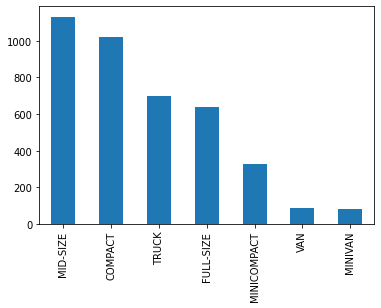

In [3]:
data['Tipo_vehiculo'].value_counts().plot(kind='bar')

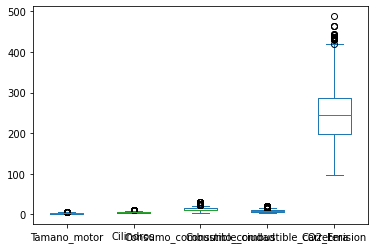

In [4]:
data.plot(kind='box')

In [5]:
#Normalizacion las variables numéricas (las dummies no se normalizan)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(data[['Tamano_motor','Cilindros','Consumo_combustible_ciudad','Consumo_combustible_carretera']]) #Ajuste de los parametros: max - min
data[['Tamano_motor','Cilindros','Consumo_combustible_ciudad','Consumo_combustible_carretera']]= min_max_scaler.transform(data[['Tamano_motor','Cilindros','Consumo_combustible_ciudad','Consumo_combustible_carretera']]) #70%
data.head()

,Tipo_vehiculo,Tamano_motor,Cilindros,Consumo_combustible_ciudad,Consumo_combustible_carretera,CO2_Emision
0,COMPACT,0.172414,0.111111,0.215909,0.162651,196
1,COMPACT,0.241379,0.111111,0.265152,0.222892,221
2,COMPACT,0.086207,0.111111,0.068182,0.108434,136
3,MID-SIZE,0.431034,0.333333,0.291667,0.222892,230
4,MID-SIZE,0.431034,0.333333,0.287879,0.240964,232


In [6]:
#Dummies para las variables predictoras
data = pd.get_dummies(data, columns=['Tipo_vehiculo'], drop_first=False)
data.head()

,Tamano_motor,Cilindros,Consumo_combustible_ciudad,Consumo_combustible_carretera,CO2_Emision,Tipo_vehiculo_COMPACT,Tipo_vehiculo_FULL-SIZE,Tipo_vehiculo_MID-SIZE,Tipo_vehiculo_MINICOMPACT,Tipo_vehiculo_MINIVAN,Tipo_vehiculo_TRUCK,Tipo_vehiculo_VAN
0,0.172414,0.111111,0.215909,0.162651,196,1,0,0,0,0,0,0
1,0.241379,0.111111,0.265152,0.222892,221,1,0,0,0,0,0,0
2,0.086207,0.111111,0.068182,0.108434,136,1,0,0,0,0,0,0
3,0.431034,0.333333,0.291667,0.222892,230,0,0,1,0,0,0,0
4,0.431034,0.333333,0.287879,0.240964,232,0,0,1,0,0,0,0


# **2.División 70-30**

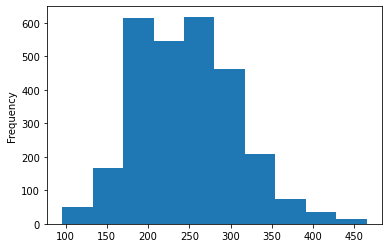

In [7]:
#División 70-30
from sklearn.model_selection import train_test_split
X = data.drop("CO2_Emision", axis = 1)
Y = data['CO2_Emision']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) #En regresion no es muestreo estratificado
Y_train.plot(kind='hist')

# **3. Predictores individuales (base learners)**

In [8]:
#Arbol de clasificación
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=20, max_depth=4)
model_dt.fit(X_train, Y_train) # 70%

#Evaluación
from sklearn import metrics
Y_pred = model_dt.predict(X_test)#  30%

#Dataframe para comparar los resultados
medidas= pd.DataFrame(index=['mse','rmse','mae','mape','max'])
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Arbol']=[mse, rmse, mae, mape,max]
medidas


,Arbol
mse,308.658779
rmse,17.568687
mae,11.158239
mape,0.043150
max,114.585987


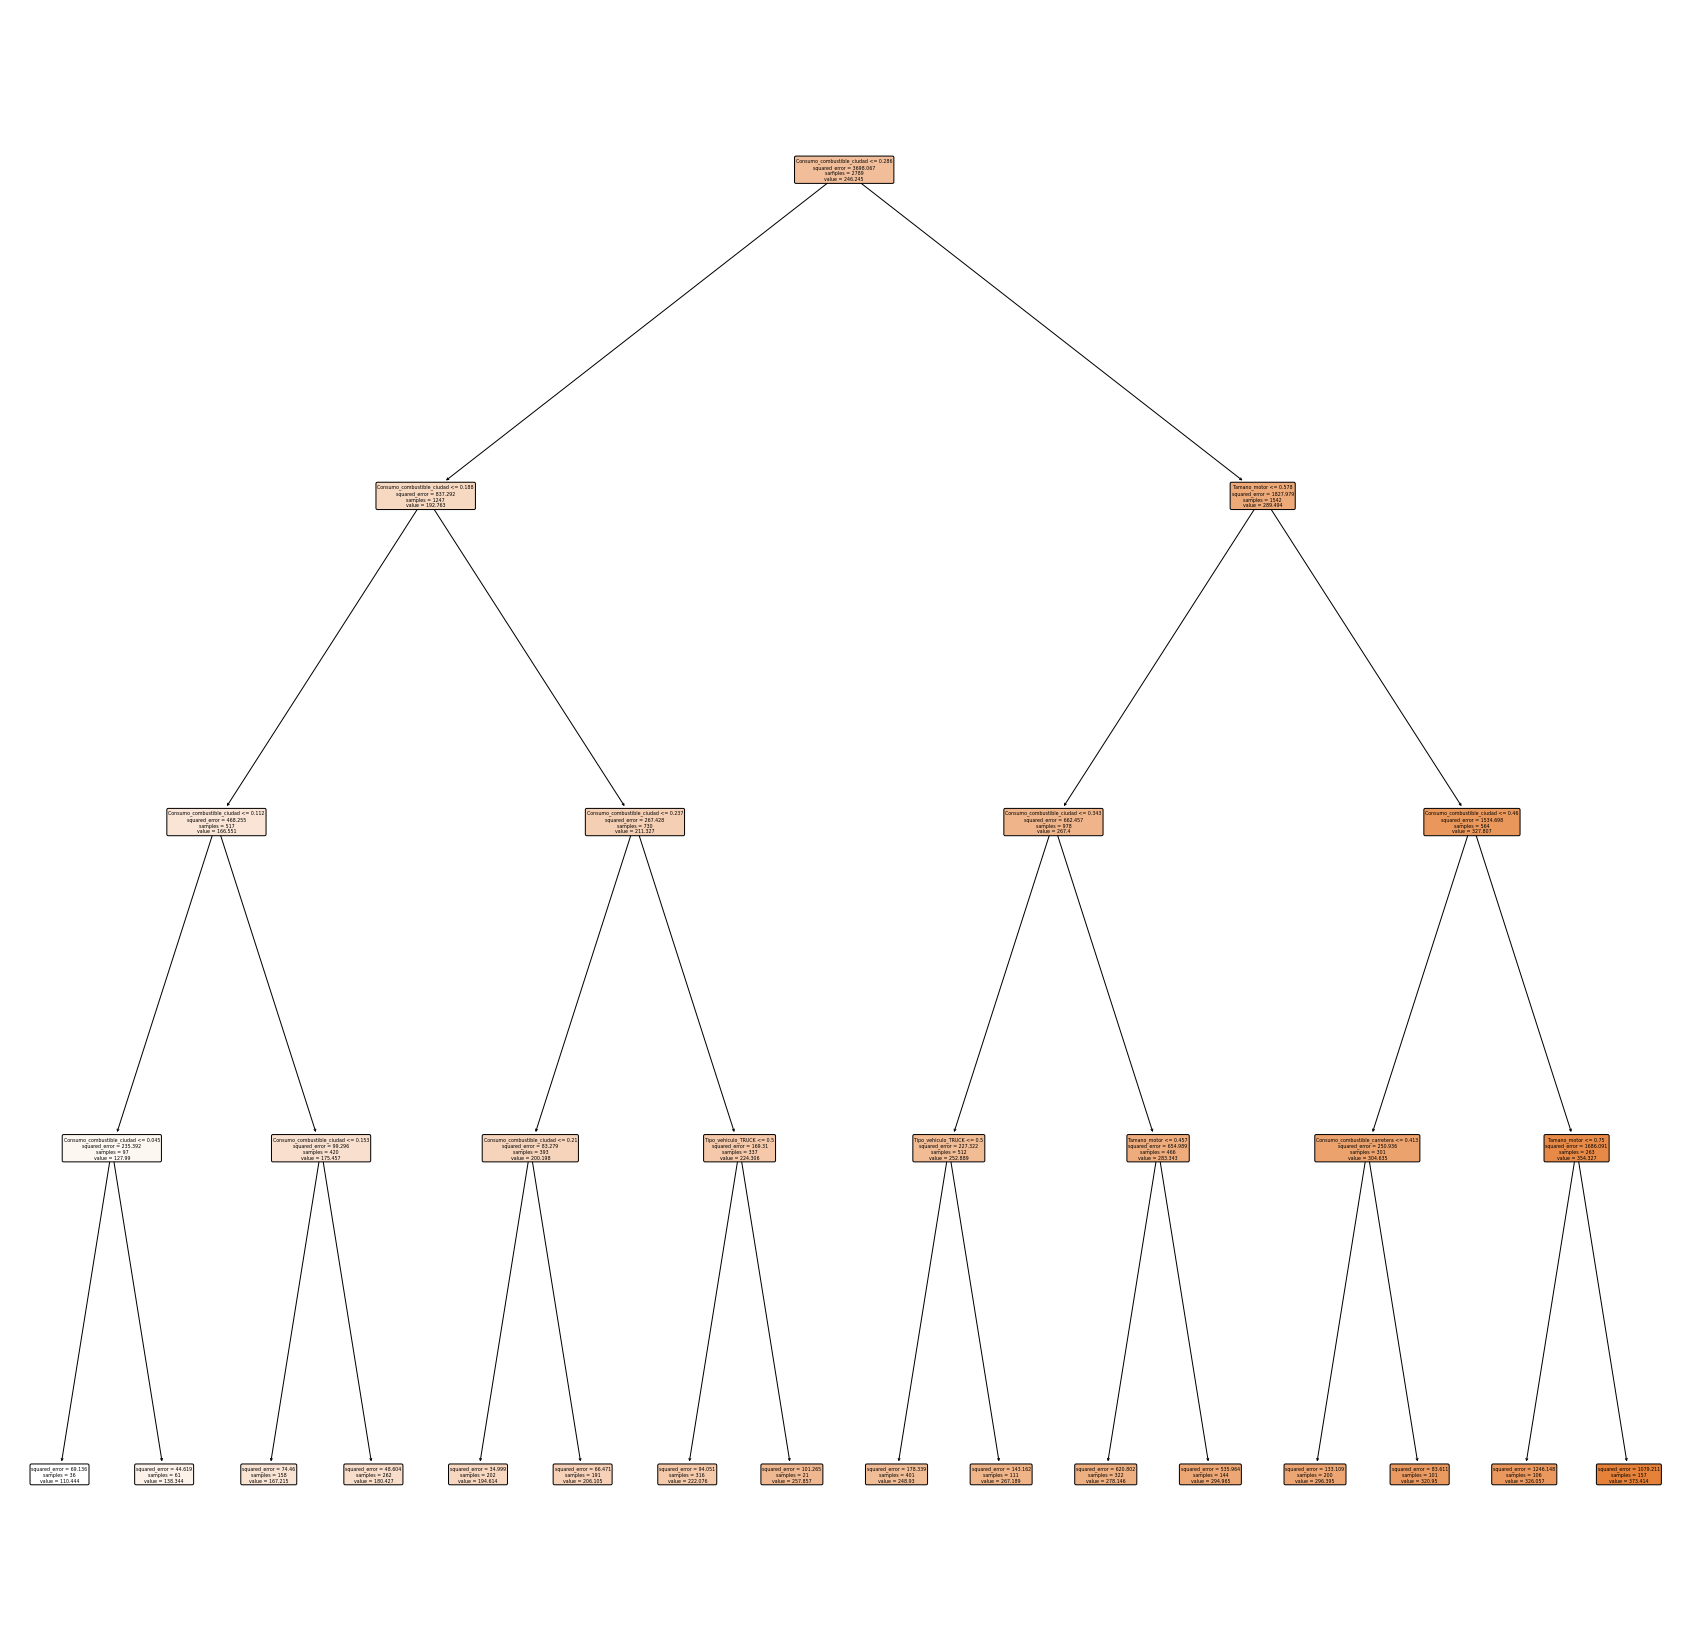

In [9]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,30))
plot_tree(model_dt, feature_names=X_train.columns.values,  rounded=True, filled=True)
plt.show() 

In [10]:
model_dt.feature_names_in_

array(['Tamano_motor', 'Cilindros', 'Consumo_combustible_ciudad',
       'Consumo_combustible_carretera', 'Tipo_vehiculo_COMPACT',
       'Tipo_vehiculo_FULL-SIZE', 'Tipo_vehiculo_MID-SIZE',
       'Tipo_vehiculo_MINICOMPACT', 'Tipo_vehiculo_MINIVAN',
       'Tipo_vehiculo_TRUCK', 'Tipo_vehiculo_VAN'], dtype=object)

In [11]:
model_dt.feature_importances_


array([0.1547869 , 0.        , 0.83528187, 0.00424542, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00568581,
       0.        ])

In [12]:
#Método Perezoso
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=1, metric='euclidean')
model_knn.fit(X_train, Y_train) 

#Evaluación
from sklearn import metrics
Y_pred = model_knn.predict(X_test)
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Knn']=[mse, rmse, mae, mape,max]
medidas




,Arbol,Knn
mse,308.658779,30.112040
rmse,17.568687,5.487444
mae,11.158239,2.403010
mape,0.043150,0.010015
max,114.585987,85.000000


In [13]:
#Red neuronal
from sklearn.neural_network import MLPRegressor
model_rn = MLPRegressor(activation="logistic",hidden_layer_sizes=(10), learning_rate='adaptive',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=500, verbose=False)
model_rn.fit(X_train, Y_train)

#Evaluación
Y_pred = model_rn.predict(X_test)
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['NN']=[mse, rmse, mae, mape,max]
medidas




,Arbol,Knn,NN
mse,308.658779,30.112040,113.864674
rmse,17.568687,5.487444,10.670739
mae,11.158239,2.403010,6.016648
mape,0.043150,0.010015,0.024218
max,114.585987,85.000000,92.917150


# 4. Bagging

In [14]:
#Bagging: Knn
from sklearn.ensemble import BaggingRegressor
modelo_base=KNeighborsRegressor(n_neighbors=1, metric='euclidean')
model_bag = BaggingRegressor(modelo_base, n_estimators=10, max_samples=0.6)
model_bag.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_bag.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Bagging']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging
mse,308.658779,30.112040,113.864674,32.018328
rmse,17.568687,5.487444,10.670739,5.658474
mae,11.158239,2.403010,6.016648,3.010535
mape,0.043150,0.010015,0.024218,0.012457
max,114.585987,85.000000,92.917150,79.100000


# 5. Random Forest (bagging)

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
model_rf= RandomForestRegressor(n_estimators=100,  max_samples=0.7, criterion='squared_error', #n_Estimators cuando modelos voy a sacar
                              max_depth=None, min_samples_leaf=2)
model_rf.fit(X_train, Y_train) #70%


#Evaluación    
Y_pred = model_rf.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Random_Forest']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest
mse,308.658779,30.112040,113.864674,32.018328,44.097779
rmse,17.568687,5.487444,10.670739,5.658474,6.640616
mae,11.158239,2.403010,6.016648,3.010535,2.854443
mape,0.043150,0.010015,0.024218,0.012457,0.012065
max,114.585987,85.000000,92.917150,79.100000,90.100417


In [16]:
# Se imprimen la importancia de las características
print('Importancia de las características')
for i, j in sorted(zip(X_train.columns, model_rf.feature_importances_)):
    print(i, j)

Importancia de las características
Cilindros 0.003001791272959821
Consumo_combustible_carretera 0.21441071612460008
Consumo_combustible_ciudad 0.6369633995608935
Tamano_motor 0.12968070756057068
Tipo_vehiculo_COMPACT 0.0003271367761249636
Tipo_vehiculo_FULL-SIZE 7.905933208402292e-05
Tipo_vehiculo_MID-SIZE 0.00023728375967822627
Tipo_vehiculo_MINICOMPACT 2.712658057673946e-05
Tipo_vehiculo_MINIVAN 1.0041031791818572e-05
Tipo_vehiculo_TRUCK 0.004580234194122033
Tipo_vehiculo_VAN 0.010682503806598125


# 6. Boosting

In [17]:
#Boosting
from sklearn.ensemble import AdaBoostRegressor
modelo_base=DecisionTreeRegressor(criterion='squared_error', max_depth=None, min_samples_leaf=2)
model_boos = AdaBoostRegressor(modelo_base, n_estimators=50)
model_boos.fit(X_train, Y_train)#70%

#Evaluación
Y_pred = model_boos.predict(X_test)#30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Boosting']=[mse, rmse, mae, mape,max]
medidas

,Arbol,Knn,NN,Bagging,Random_Forest,Boosting
mse,308.658779,30.112040,113.864674,32.018328,44.097779,30.604417
rmse,17.568687,5.487444,10.670739,5.658474,6.640616,5.532126
mae,11.158239,2.403010,6.016648,3.010535,2.854443,2.424063
mape,0.043150,0.010015,0.024218,0.012457,0.012065,0.010346
max,114.585987,85.000000,92.917150,79.100000,90.100417,88.000000


# 7. Votación "hard"

In [18]:
#Votación hard
from sklearn.ensemble import VotingRegressor

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

model_vot_hard = VotingRegressor(estimators=regresores, weights=None)
model_vot_hard.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_hard.predict(X_test)#30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Votacion_hard']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard
mse,308.658779,30.112040,113.864674,32.018328,44.097779,30.604417,84.742010
rmse,17.568687,5.487444,10.670739,5.658474,6.640616,5.532126,9.205542
mae,11.158239,2.403010,6.016648,3.010535,2.854443,2.424063,5.299470
mape,0.043150,0.010015,0.024218,0.012457,0.012065,0.010346,0.020781
max,114.585987,85.000000,92.917150,79.100000,90.100417,88.000000,78.312231


# 8. Votación "soft"

In [19]:
#Votación soft

from sklearn.ensemble import VotingRegressor

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]
model_vot_soft = VotingRegressor(estimators=regresores, weights=[0.2, 0.4, 0.3])
model_vot_soft.fit(X_train,Y_train) #70%

#Evaluación
Y_pred = model_vot_soft.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Votacion_soft']=[mse, rmse, mae, mape,max]
medidas



,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard,Votacion_soft
mse,308.658779,30.112040,113.864674,32.018328,44.097779,30.604417,84.742010,64.571532
rmse,17.568687,5.487444,10.670739,5.658474,6.640616,5.532126,9.205542,8.035641
mae,11.158239,2.403010,6.016648,3.010535,2.854443,2.424063,5.299470,4.574328
mape,0.043150,0.010015,0.024218,0.012457,0.012065,0.010346,0.020781,0.018061
max,114.585987,85.000000,92.917150,79.100000,90.100417,88.000000,78.312231,75.624693


# 9. Stacking

In [20]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

regresores= [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

metodo_ensamblador= LinearRegression()

#metodo_ensamblador = SVC(kernel='linear', probability=True) #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

model_stack= StackingRegressor(estimators=regresores, final_estimator=metodo_ensamblador)
model_stack.fit(X_train,Y_train)#70%

#Evaluación
Y_pred = model_stack.predict(X_test) #30%
mse = metrics.mean_squared_error(Y_test,Y_pred) # Entre mas pequeño mejor
rmse = np.sqrt(mse) #diferencia entre el valor real y la prediccion
mae= metrics.mean_absolute_error(Y_test,Y_pred) #diferencia entre el valor real y la prediccion
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred) # error en porcentaje
max=metrics.max_error(Y_test,Y_pred)
medidas['Stacking']=[mse, rmse, mae, mape,max]
medidas


,Arbol,Knn,NN,Bagging,Random_Forest,Boosting,Votacion_hard,Votacion_soft,Stacking
mse,308.658779,30.112040,113.864674,32.018328,44.097779,30.604417,84.742010,64.571532,29.086571
rmse,17.568687,5.487444,10.670739,5.658474,6.640616,5.532126,9.205542,8.035641,5.393197
mae,11.158239,2.403010,6.016648,3.010535,2.854443,2.424063,5.299470,4.574328,2.745543
mape,0.043150,0.010015,0.024218,0.012457,0.012065,0.010346,0.020781,0.018061,0.011284
max,114.585987,85.000000,92.917150,79.100000,90.100417,88.000000,78.312231,75.624693,82.835434


# **10. Guardamos el mejor modelo**

In [21]:
import pickle
filename = 'modelo-ensamble-reg.pkl'
variables=X.columns._values
pickle.dump([model_boos,variables, min_max_scaler], open(filename, 'wb'))

